# 🚗 Project Summary: Predicting Daily Car Accidents

**Our project is to build a linear regression model to predict how many car accidents happen on a given day based on date-related and weather-related features.**

 

<a id="p1"></a>
# 1.  Importing Packages
We use the same modules as we would use for any problem working with data. We have numpy and pandas to work with numbers and data, and we have seaborn and matplotlib to visualize data. We would also like to filter out unnecessary warnings.

In [7]:
import numpy as np 
import pandas as pd 
import holidays
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

<a id="p2"></a>
#  Loading and Inspecting Data
With various Pandas functions, we load our training and test data set as well as inspect it to get an idea of the data we're working with. Wow! That is a large data set; just take a look at its shape. We're going to have to understand our data before modelling. 

In [17]:
train_df = pd.read_csv('/kaggle/input/us-accidents/US_Accidents_March23.csv')


 

In [19]:
train_df.shape

(7728394, 46)

In [20]:
train_df.describe()



,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


<a id="p2"></a>
#  Cleaning Data

In [21]:
train_df = train_df.drop(['Start_Lat','Start_Lng','End_Lat','End_Lng','Description','Street',
                          'City','County','Zipcode','Country','Timezone','Airport_Code',
                          'Weather_Timestamp','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], axis=1)



In [23]:
print(train_df['Source'].value_counts().sort_index())
my_df = train_df[train_df['Source'] == train_df['Source'].value_counts().idxmax()].reset_index(drop=True)
my_df.shape

Source
Source1    4325632
Source2    3305373
Source3      97389
Name: count, dtype: int64


(4325632, 30)

In [24]:
my_df['Temperature(C)'] = (my_df['Temperature(F)'] - 32) * 5.0 / 9.0
bins = [-50, -20, -10, 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['< -20°C', '-20–-10°C', '-10–0°C', '0–10°C', '10–20°C', '20–30°C', '30–40°C', '40–50°C', '50+°C']
my_df['Temperature_Range'] = pd.cut(my_df['Temperature(C)'], bins=bins, labels=labels, right=False)
print (my_df['Temperature_Range'].value_counts().sort_index())

Temperature_Range
< -20°C         7958
-20–-10°C      45127
-10–0°C       274551
0–10°C        788351
10–20°C      1327873
20–30°C      1413811
30–40°C       355414
40–50°C         6370
50+°C             31
Name: count, dtype: int64


In [25]:
temp_ranges = {
    "< -20°C": -20,
    "-20–-10°C": -15,
    "-10–0°C": -5,
    "0–10°C": 5,
    "10–20°C": 15,
    "20–30°C": 25,
    "30–40°C": 35,
    "40–50°C": 45,
    "50+°C": 50
}

my_df['Temperature_Midpoint'] = my_df['Temperature_Range'].map(temp_ranges)
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Temperature_Midpoint']])
#encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Temperature_Midpoint']))
encoded_df = pd.DataFrame(
    encoded_array, 
    columns=[f"Temperature_Range_{cat}" for cat in encoder.categories_[0]]
)
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)
print(my_df_encoded)











                ID   Source  Severity           Start_Time  \
0        A-3412645  Source1         3  2016-02-08 00:37:08   
1        A-3412646  Source1         2  2016-02-08 05:56:20   
2        A-3412647  Source1         2  2016-02-08 06:15:39   
3        A-3412648  Source1         2  2016-02-08 06:15:39   
4        A-3412649  Source1         2  2016-02-08 06:51:45   
...            ...      ...       ...                  ...   
4325627  A-7777757  Source1         2  2019-08-23 18:03:25   
4325628  A-7777758  Source1         2  2019-08-23 19:11:30   
4325629  A-7777759  Source1         2  2019-08-23 19:00:21   
4325630  A-7777760  Source1         2  2019-08-23 19:00:21   
4325631  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Distance(mi) State  Temperature(F)  \
0        2016-02-08 06:37:08         3.230    OH            42.1   
1        2016-02-08 11:56:20         0.747    OH            36.9   
2        2016-02-08 12:15:39         0.055    OH   

In [26]:
my_df['Wind_Chill(C)'] = (my_df['Wind_Chill(F)'] - 32) * 5.0 / 9.0
my_df = my_df.drop(['Wind_Chill(F)'], axis=1)
bins = [-50, -20, -10, 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['< -20°C', '-20–-10°C', '-10–0°C', '0–10°C', '10–20°C', '20–30°C', '30–40°C', '40–50°C', '50+°C']
my_df['Wind_Chill_Range'] = pd.cut(my_df['Wind_Chill(C)'], bins=bins, labels=labels, right=False)
print (my_df['Wind_Chill_Range'].value_counts().sort_index())

Wind_Chill_Range
< -20°C        32229
-20–-10°C      91494
-10–0°C       350576
0–10°C        592978
10–20°C      1161769
20–30°C      1241695
30–40°C       311920
40–50°C         5354
50+°C             26
Name: count, dtype: int64


In [27]:
# Create bins and labels for Humidity range
humidity_bins = [0, 20, 40, 60, 80, 100]
humidity_labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']
my_df['Humidity_Range'] = pd.cut(my_df['Humidity(%)'], bins=humidity_bins, labels=humidity_labels, include_lowest=True)

# Count the number of records in each humidity range
humidity_range_counts = my_df['Humidity_Range'].value_counts().sort_index()

encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Humidity_Range']])
# Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=[f"Humidity_Range_{cat}" for cat in encoder.categories_[0]]
)
# Concatenate the original dataframe with the one-hot encoded columns
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)

print("\nEncoded DataFrame:")
print(my_df_encoded)







Encoded DataFrame:
                ID   Source  Severity           Start_Time  \
0        A-3412645  Source1         3  2016-02-08 00:37:08   
1        A-3412646  Source1         2  2016-02-08 05:56:20   
2        A-3412647  Source1         2  2016-02-08 06:15:39   
3        A-3412648  Source1         2  2016-02-08 06:15:39   
4        A-3412649  Source1         2  2016-02-08 06:51:45   
...            ...      ...       ...                  ...   
4325627  A-7777757  Source1         2  2019-08-23 18:03:25   
4325628  A-7777758  Source1         2  2019-08-23 19:11:30   
4325629  A-7777759  Source1         2  2019-08-23 19:00:21   
4325630  A-7777760  Source1         2  2019-08-23 19:00:21   
4325631  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Distance(mi) State  Temperature(F)  Humidity(%)  \
0        2016-02-08 06:37:08         3.230    OH            42.1         58.0   
1        2016-02-08 11:56:20         0.747    OH            36.9         

In [28]:
# Define bins and labels for Visibility ranges
visibility_bins = [0, 1, 3, 5, 10, 20, float('inf')]
visibility_labels = ['0-1 mi', '1-3 mi', '3-5 mi', '5-10 mi', '10-20 mi', '20+ mi']

# Bin the Visibility(mi) values
my_df['Visibility_Range'] = pd.cut(my_df['Visibility(mi)'], bins=visibility_bins, labels=visibility_labels, include_lowest=True)

# Count the number of records in each range
visibility_counts = my_df['Visibility_Range'].value_counts().sort_index()

# Display the result
print("Visibility Range Counts:")
print(visibility_counts)

visibility_bins = [0, 1, 3, 5, 10, 20, float('inf')]
visibility_labels = ['0-1 mi', '1-3 mi', '3-5 mi', '5-10 mi', '10-20 mi', '20+ mi']
my_df['Visibility_Range'] = pd.cut(my_df['Visibility(mi)'], bins=visibility_bins, labels=visibility_labels, right=False)

encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Visibility_Range']])
# Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=[f"Visibility_Range_{cat}" for cat in encoder.categories_[0]]
)
# Concatenate the original dataframe with the one-hot encoded columns
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)

print("\nEncoded DataFrame:")
print(my_df_encoded)



Visibility Range Counts:
Visibility_Range
0-1 mi       137770
1-3 mi       149697
3-5 mi       142448
5-10 mi     3768744
10-20 mi      11011
20+ mi         4458
Name: count, dtype: int64

Encoded DataFrame:
                ID   Source  Severity           Start_Time  \
0        A-3412645  Source1         3  2016-02-08 00:37:08   
1        A-3412646  Source1         2  2016-02-08 05:56:20   
2        A-3412647  Source1         2  2016-02-08 06:15:39   
3        A-3412648  Source1         2  2016-02-08 06:15:39   
4        A-3412649  Source1         2  2016-02-08 06:51:45   
...            ...      ...       ...                  ...   
4325627  A-7777757  Source1         2  2019-08-23 18:03:25   
4325628  A-7777758  Source1         2  2019-08-23 19:11:30   
4325629  A-7777759  Source1         2  2019-08-23 19:00:21   
4325630  A-7777760  Source1         2  2019-08-23 19:00:21   
4325631  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Distance(mi) Stat

In [29]:
print(my_df['Distance(mi)'].value_counts().sort_index())

my_df['Distance(km)'] = my_df['Distance(mi)'] * 1.60934
bins_km = [0, 5, 10, 25, 50, float('inf')]
labels_km = ['0–5 km', '5-10 km', '10–25 km', '25-50 km', '50+ km']
my_df['Distance_Range'] = pd.cut(my_df['Distance(km)'], bins=bins_km, labels=labels_km, right=False)
print(my_df['Distance_Range'].value_counts().sort_index())

Distance(mi)
0.000      401472
0.001        5585
0.002        3078
0.003        4263
0.004        6337
            ...  
150.138         1
151.525         1
152.543         1
153.663         1
155.186         1
Name: count, Length: 19240, dtype: int64
Distance_Range
0–5 km      4070995
5-10 km      187018
10–25 km      60648
25-50 km       5337
50+ km         1634
Name: count, dtype: int64


In [30]:
def classify_precip(p):
    if pd.isna(p) or p == 0:
        return 'None'
    elif p < 0.10:
        return 'Light'
    elif p <= 0.30:
        return 'Moderate'
    else:
        return 'Heavy'

my_df['Precipitation_Level'] = my_df['Precipitation(in)'].apply(classify_precip)
my_df['Precipitation_Level'].value_counts().sort_index()

encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Precipitation_Level']])
# Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=[f"Precipitation_Level_{cat}" for cat in encoder.categories_[0]]
)
# Concatenate the original dataframe with the one-hot encoded columns
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)

print("\nEncoded DataFrame:")
print(my_df_encoded)


Encoded DataFrame:
                ID   Source  Severity           Start_Time  \
0        A-3412645  Source1         3  2016-02-08 00:37:08   
1        A-3412646  Source1         2  2016-02-08 05:56:20   
2        A-3412647  Source1         2  2016-02-08 06:15:39   
3        A-3412648  Source1         2  2016-02-08 06:15:39   
4        A-3412649  Source1         2  2016-02-08 06:51:45   
...            ...      ...       ...                  ...   
4325627  A-7777757  Source1         2  2019-08-23 18:03:25   
4325628  A-7777758  Source1         2  2019-08-23 19:11:30   
4325629  A-7777759  Source1         2  2019-08-23 19:00:21   
4325630  A-7777760  Source1         2  2019-08-23 19:00:21   
4325631  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Distance(mi) State  Temperature(F)  Humidity(%)  \
0        2016-02-08 06:37:08         3.230    OH            42.1         58.0   
1        2016-02-08 11:56:20         0.747    OH            36.9         

In [31]:
print(my_df['Weather_Condition'].unique())

my_df['Weather_Simplified'] = 'Other'

my_df.loc[my_df['Weather_Condition'].str.contains(r'Snow|Sleet|Hail|Ice', case=False, na=False), 'Weather_Simplified'] = 'Snow'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Rain|Precipitation|Drizzle', case=False, na=False), 'Weather_Simplified'] = 'Rain'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Thunder|T-Storm', case=False, na=False), 'Weather_Simplified'] = 'Thunder'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Cloud|Overcast', case=False, na=False), 'Weather_Simplified'] = 'Cloudy'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Fog|Haze|Mist', case=False, na=False), 'Weather_Simplified'] = 'Fog'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Dust|Sand', case=False, na=False), 'Weather_Simplified'] = 'Dust'
my_df.loc[my_df['Weather_Condition'].str.contains('Smoke', case=False, na=False), 'Weather_Simplified'] = 'Smoke'
my_df.loc[my_df['Weather_Condition'].str.contains('Fair', case=False, na=False), 'Weather_Simplified'] = 'Fair'
my_df.loc[my_df['Weather_Condition'].str.contains('Wintry', case=False, na=False), 'Weather_Simplified'] = 'Wintry'
my_df.loc[my_df['Weather_Condition'].str.contains('Squalls', case=False, na=False), 'Weather_Simplified'] = 'Squalls'
my_df = my_df.drop(['Weather_Condition'], axis=1)

print(my_df['Weather_Simplified'].value_counts().head(20))

['Light Rain' 'Overcast' 'Mostly Cloudy' 'Snow' 'Light Snow' 'Cloudy' nan
 'Scattered Clouds' 'Clear' 'Partly Cloudy' 'Light Freezing Drizzle'
 'Light Drizzle' 'Haze' 'Rain' 'Heavy Rain' 'Fair' 'Drizzle' 'Fog'
 'Thunderstorms and Rain' 'Patches of Fog' 'Light Thunderstorms and Rain'
 'Mist' 'Rain Showers' 'Light Rain Showers' 'Heavy Drizzle' 'Smoke'
 'Light Freezing Fog' 'Light Freezing Rain' 'Blowing Snow'
 'Heavy Thunderstorms and Rain' 'Heavy Snow' 'Snow Grains' 'Squalls'
 'Light Fog' 'Shallow Fog' 'Thunderstorm' 'Light Ice Pellets' 'Thunder'
 'Thunder in the Vicinity' 'Fair / Windy' 'Light Rain with Thunder'
 'Heavy Thunderstorms and Snow' 'Light Snow Showers' 'Cloudy / Windy'
 'Ice Pellets' 'N/A Precipitation' 'Light Thunderstorms and Snow'
 'T-Storm' 'Rain / Windy' 'Wintry Mix' 'Partly Cloudy / Windy'
 'Heavy T-Storm' 'Sand' 'Light Rain / Windy' 'Widespread Dust'
 'Mostly Cloudy / Windy' 'Blowing Dust / Windy' 'Blowing Dust'
 'Volcanic Ash' 'Freezing Rain / Windy' 'Small Hail' 'W

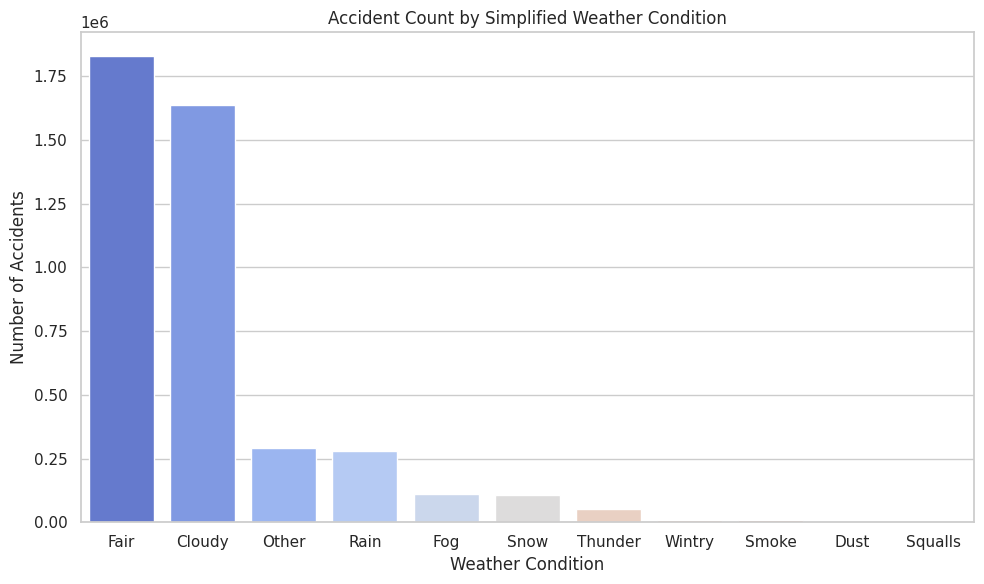

In [40]:
accidents_by_weather = my_df['Weather_Simplified'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_by_weather.index, y=accidents_by_weather.values, palette="coolwarm")
plt.title("Accident Count by Simplified Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

In [41]:
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(my_df[['Weather_Simplified']])
# Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=[f"Weather_Simplified_{cat}" for cat in encoder.categories_[0]]
)
# Concatenate the original dataframe with the one-hot encoded columns
my_df_encoded = pd.concat([my_df, encoded_df], axis=1)

print("\nEncoded DataFrame:")
print(my_df_encoded)


Encoded DataFrame:
                ID   Source  Severity           Start_Time  \
0        A-3412645  Source1         3  2016-02-08 00:37:08   
1        A-3412646  Source1         2  2016-02-08 05:56:20   
2        A-3412647  Source1         2  2016-02-08 06:15:39   
3        A-3412648  Source1         2  2016-02-08 06:15:39   
4        A-3412649  Source1         2  2016-02-08 06:51:45   
...            ...      ...       ...                  ...   
4325627  A-7777757  Source1         2  2019-08-23 18:03:25   
4325628  A-7777758  Source1         2  2019-08-23 19:11:30   
4325629  A-7777759  Source1         2  2019-08-23 19:00:21   
4325630  A-7777760  Source1         2  2019-08-23 19:00:21   
4325631  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Distance(mi) State  Temperature(F)  Humidity(%)  \
0        2016-02-08 06:37:08         3.230    OH            42.1         58.0   
1        2016-02-08 11:56:20         0.747    OH            36.9         

In [ ]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'], errors='coerce')
print("Total rows : ", my_df.shape[0])
print("Valid rows : ", my_df[my_df['Start_Time'].notna()].shape[0])
my_df = my_df[my_df['Start_Time'].notna()]

### <a id="p2"></a>
# 3. EDA

Accidents per day:

Group by date and count accidents.

Plot a time series to check trends (e.g., increasing/decreasing).


In [ ]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])

# Extract just the date part (without time)
my_df['Date'] = my_df['Start_Time'].dt.date

# Group by date and count the number of accidents
accidents_per_day = my_df.groupby('Date').size().reset_index(name='accident_count')

# Convert 'Date' back to datetime for proper plotting
accidents_per_day['Date'] = pd.to_datetime(accidents_per_day['Date'])

# Plot the time series
plt.figure(figsize=(15, 6))
sns.lineplot(data=accidents_per_day, x='Date', y='accident_count')
plt.title("Accidents Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()

Day of week effects:

Are weekends more dangerous than weekdays?

In [ ]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])

# Extract day of the week (0=Monday, 6=Sunday)
my_df['DayOfWeek'] = my_df['Start_Time'].dt.dayofweek
my_df['DayName'] = my_df['Start_Time'].dt.day_name()

# Group by day name and count number of accidents
accidents_by_day = my_df['DayName'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_by_day.index, y=accidents_by_day.values, palette='viridis')
plt.title("Total Accidents by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What time are most accidents happening? (Rush hours?)

In [ ]:

# Convert to datetime if not already
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])

# Extract the hour of the day (0 to 23)
my_df['Hour'] = my_df['Start_Time'].dt.hour

# Count accidents by hour
accidents_by_hour = my_df['Hour'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=accidents_by_hour.index, y=accidents_by_hour.values, palette='rocket')
plt.title("Accidents by Hour of the Day")
plt.xlabel("Hour (24-hour format)")
plt.ylabel("Number of Accidents")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


suggestion is to create  a new feature: rush_hour = (7–8 AM or 4–6 PM)

Do winter months see more accidents?

In [ ]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])

# Extract month and month name
my_df['Month'] = my_df['Start_Time'].dt.month
my_df['MonthName'] = my_df['Start_Time'].dt.month_name()

# Group by month name
accidents_by_month = my_df['MonthName'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=accidents_by_month.index, y=accidents_by_month.values, palette='coolwarm')
plt.title("Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(accidents_by_month)

Correlation between each weather condition and accident count.

Accident rate by weather condition:

More accidents during rainy or snowy days?

In [ ]:
weather_counts = my_df['Weather_Simplified'].value_counts()
my_df['Weather_Simple'] = my_df['Weather_Simplified'].str.lower()
# Define weather keywords
def simplify_weather(condition):
    if pd.isna(condition): return 'Unknown'
    if 'rain' in condition: return 'Rain'
    if 'snow' in condition: return 'Snow'
    if 'Dust' in condition: return 'Dust'
    if 'fog' in condition or 'haze' in condition: return 'Fog'
    if 'storm' in condition or 'thunder' in condition: return 'Storm'
    if 'clear' in condition: return 'Clear'
    if 'cloud' in condition: return 'Cloudy'
    return 'Other'

my_df['Weather_Grouped'] = my_df['Weather_Simple'].apply(simplify_weather)

accidents_by_weather = my_df['Weather_Grouped'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_by_weather.index, y=accidents_by_weather.values, palette="coolwarm")
plt.title("Accident Count by Simplified Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

Do more accidents happen near traffic signals?

Does this rate change by:

Time of day? (e.g., are intersections more dangerous during rush hours?)

Weather? (e.g., rain + traffic light = more accidents?)

Is there a correlation between traffic signals and accident severity or distance?

In [ ]:
signal_counts = my_df['Traffic_Signal'].value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=signal_counts.index, y=signal_counts.values, palette='viridis')
plt.xticks([0,1], ['No Traffic Signal', 'Traffic Signal'])
plt.ylabel("Accident Count")
plt.title("Accidents With vs Without Traffic Signals")
plt.tight_layout()
plt.show()


Does this rate change by time of day?

In [ ]:
# Extract hour
my_df['Hour'] = pd.to_datetime(my_df['Start_Time']).dt.hour

# Group by hour and calculate traffic signal rate
hourly_signal_rate = my_df.groupby('Hour')['Traffic_Signal'].mean()

# Plot
plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_signal_rate.index, y=hourly_signal_rate.values, marker='o')
plt.title("Traffic Signal Accident Rate by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Proportion of Accidents Near Traffic Signals")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()



Does this rate change by weather condition?

In [ ]:
def simplify_weather(condition):
    if pd.isna(condition): return 'Unknown'
    cond = condition.lower()
    if 'rain' in cond: return 'Rain'
    if 'snow' in cond: return 'Snow'
    if 'fog' in cond or 'haze' in cond: return 'Fog'
    if 'storm' in cond or 'thunder' in cond: return 'Storm'
    if 'clear' in cond: return 'Clear'
    if 'cloud' in cond: return 'Cloudy'
    return 'Other'

my_df['Weather_Grouped'] = my_df['Weather_Condition'].apply(simplify_weather)

weather_signal_rate = my_df.groupby('Weather_Grouped')['Traffic_Signal'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=weather_signal_rate.index, y=weather_signal_rate.values, palette="coolwarm")
plt.title("Traffic Signal Rate by Weather Condition")
plt.ylabel("Proportion of Accidents Near Traffic Signals")
plt.xlabel("Weather")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Are accidents more likely to occur near stations?

Is this rate higher in urban vs. rural areas?

Do high station rates correlate with shorter travel distances or less severity?

In [ ]:
station_counts = my_df['Station'].value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=station_counts.index, y=station_counts.values, palette='crest')
plt.xticks([0,1], ['No Station Nearby', 'Station Nearby'])
plt.ylabel("Accident Count")
plt.title("Accidents Near Stations vs Not")
plt.tight_layout()
plt.show()


Correlation between traffic signal and severity / distance

In [ ]:
correlations = my_df[['Traffic_Signal', 'Severity', 'Distance(mi)']].corr()

plt.figure(figsize=(5,4))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: Traffic Signal, Severity, Distance")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=my_df, x='Distance(mi)', y='Severity', alpha=0.4)
plt.title("Scatter Plot: Distance vs Severity")
plt.xlabel("Distance (miles)")
plt.ylabel("Severity")
plt.tight_layout()
plt.show()

In [ ]:
correlation = my_df['Distance(mi)'].corr(my_df['Severity'])
print(f"Correlation between Distance and Severity: {correlation:.3f}")
sns.lmplot(data=my_df, x='Distance(mi)', y='Severity', line_kws={"color": "red"})
plt.title("Distance vs Severity with Regression Line")
plt.tight_layout()
plt.show()

Conclusion.It seems to be a very weak correlation between severity and distance
In our dataset, accident distance and severity are mostly unrelated. A long accident zone doesn't necessarily mean it's more or less severe.

In [ ]:
severity_counts = my_df['Severity'].value_counts().sort_index() 
plt.figure(figsize=(8,5))
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='viridis')
plt.title("Accident Count by Severity Level")
plt.xlabel("Severity")
plt.ylabel("Number of Accidents")
plt.xticks(ticks=[0,1,2,3], labels=['1 (Low)', '2', '3', '4 (High)'])  # optional pretty labels
plt.tight_layout()
plt.show()

In [ ]:
my_df['Date'] = pd.to_datetime( my_df['Start_Time']).dt.date
daily_severity = my_df.groupby(['Date', 'Severity']).size().reset_index(name='Accident_Count')
pivot_df = daily_severity.pivot(index='Date', columns='Severity', values='Accident_Count').fillna(0)
pivot_df.plot(figsize=(12,6))
plt.title("Daily Accident Count by Severity Level")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()


#pivot_df = daily_severity.pivot(index='Date', columns='Severity', values='Accident_Count').fillna(0)
#pivot_df.plot(kind='area', stacked=True, figsize=(12,6), colormap='viridis')
#plt.title("Daily Accident Count by Severity Level")
#plt.xlabel("Date")
#plt.ylabel("Number of Accidents")
#plt.legend(title="Severity")
#plt.tight_layout()
#plt.show()

We want to measure the correlation between accident count and severity

In [ ]:
my_df['Date'] = pd.to_datetime(my_df['Start_Time']).dt.date

# Group by Date and calculate accident count and average severity

daily_stats = my_df.groupby('Date').agg(
    accident_count=pd.NamedAgg(column='Severity', aggfunc='size'),
    avg_severity=pd.NamedAgg(column='Severity', aggfunc='mean')
).reset_index()


print(daily_stats.head())
correlation = daily_stats['accident_count'].corr(daily_stats['avg_severity'])
print(f"Correlation between accident count and average severity: {correlation:.3f}")

We are building a model to predict the number of accidents per day and we are wondering whether to include:

1. Severity (average severity of accidents on that day)

2. Distance(mi) (average distance of accidents on that day)


-0.486 suggests that there is a moderate negative correlation between accident count and severity.
More accidents tend to correlate with lower severity, but the relationship is not very strong.

So,it seems, that Severity is not a cause of accident count — it's more like a result or outcome of an accident.
Including average severity per day as a feature to predict accident count per day would create a causal confusion. And should not be taken as feature.

In [ ]:
my_df[['Temperature(C)', 'Humidity(%)', 'Wind_Chill(C)']].describe()
my_df[['Temperature(C)', 'Humidity(%)', 'Wind_Chill(C)']].isna().mean()
for col in ['Temperature(C)', 'Humidity(%)', 'Wind_Chill(C)']:
    sns.histplot(my_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])
my_df['date'] = my_df['Start_Time'].dt.date

daily_stats = my_df.groupby('date').agg({
    'Temperature(C)': 'mean',
    'Humidity(%)': 'mean',
    'Wind_Chill(C)': 'mean',
    'ID': 'count'  # or your accident ID
}).rename(columns={'ID': 'accident_count'})



sns.scatterplot(x='Temperature(C)', y='accident_count', data=daily_stats)
plt.title('Accident Count vs Temperature')
plt.show()

sns.scatterplot(x='Humidity(%)', y='accident_count', data=daily_stats)
plt.title('Accident Count vs Humidity')
plt.show()

daily_stats.corr()['accident_count']

### 🔍 Quick Recap of Correlations

| **Feature**         | **Correlation with `accident_count`** | **Interpretation**                |
|---------------------|----------------------------------------|------------------------------------|
| Temperature (°C)     | `-0.023413`                                | Negligible correlation             |
| Humidity (%)         | `+0.026`                                | Weak positive correlation          |
| Wind Chill (°F)      | `0.177`                                | Negligible negative correlation    |


In [ ]:

# Convert Start_Time to datetime and extract date
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])
my_df['date'] = my_df['Start_Time'].dt.date

# Group by date to get daily accident count and most common Wind_Direction
daily_df = my_df.groupby('date').agg({
    'Wind_Direction': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'ID': 'count'  # or len(x) if 'ID' is not available
}).rename(columns={'ID': 'accident_count'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_df, x='Wind_Direction', y='accident_count', estimator='mean', ci=None)
plt.xticks(rotation=45)
plt.title('Average Daily Accident Count by Wind Direction')
plt.xlabel('Wind Direction')
plt.ylabel('Average Accident Count')
plt.tight_layout()
plt.show()


In [ ]:
# Ensure Start_Time is datetime and extract date
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])
my_df['date'] = my_df['Start_Time'].dt.date

# Group by date and calculate daily stats
daily_df = my_df.groupby('date').agg({
    'ID': 'count',  # daily accident count
    'Visibility(mi)': 'mean'  # average visibility
}).rename(columns={'ID': 'accident_count'}).reset_index()

print(daily_df)

# Plotting correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=daily_df, x='Visibility(mi)', y='accident_count')
sns.regplot(data=daily_df, x='Visibility(mi)', y='accident_count', scatter=False, color='red')
plt.title('Visibility vs. Daily Accident Count')
plt.xlabel('Average Daily Visibility (mi)')
plt.ylabel('Accident Count')
plt.tight_layout()
plt.show()

# Calculate and print correlation
correlation = daily_df['Visibility(mi)'].corr(daily_df['accident_count'])
print(f"Correlation between Visibility and Accident Count: {correlation:.3f}")


In [ ]:

# Make sure Start_Time is datetime and extract date
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])
my_df['date'] = my_df['Start_Time'].dt.date

# Group by date to get daily average temperature and accident count
daily_df = my_df.groupby('date').agg({
    'ID': 'count',  # number of accidents
    'Temperature(C)': 'mean'  # average temperature
}).rename(columns={'ID': 'accident_count'}).reset_index()

# Plot: Temperature vs Accident Count
plt.figure(figsize=(8, 6))
sns.scatterplot(data=daily_df, x='Temperature(C)', y='accident_count')
sns.regplot(data=daily_df, x='Temperature(C)', y='accident_count', scatter=False, color='red')
plt.title('Temperature vs. Daily Accident Count')
plt.xlabel('Average Daily Temperature (°C)')
plt.ylabel('Accident Count')
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = daily_df['Temperature(C)'].corr(daily_df['accident_count'])
print(f"Correlation between Temperature and Accident Count: {correlation:.3f}")


#### Correlation Analysis: Temperature vs. Accident Count

- **Correlation coefficient**: -0.023  
- **Interpretation**: This is a **negligible** positive correlation, meaning changes in temperature have **almost no linear relationship** with the number of accidents reported per day.  
- **Conclusion**: Temperature may **not be a strong predictive feature** for modeling daily accident counts using linear regression.


A correlation of –0.006 between Visibility and Accident Count indicates a negligible (almost zero) linear relationship

In [ ]:

# Step 1: Create a binary flag for precipitation
my_df['Precipitation_Flag'] = my_df['Precipitation(in)'] > 0
daily_accidents = my_df.groupby(['Date', 'Precipitation_Flag']).size().reset_index(name='accident_count')
avg_accidents = daily_accidents.groupby('Precipitation_Flag')['accident_count'].mean().reset_index()
correlation = daily_accidents['Precipitation_Flag'].corr(daily_accidents['accident_count'])

# Step 2: Group by Precipitation Flag and calculate average accident count
#avg_accidents = my_df.groupby('Precipitation_Flag')['accident_count'].mean().reset_index()

# Step 3: Plot
sns.barplot(data=avg_accidents, x='Precipitation_Flag', y='accident_count')
plt.xticks([0, 1], ['No Precipitation', 'Precipitation'])
plt.title('Average Daily Accident Count by Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Average Accident Count')
plt.show()
print(f"Correlation between Precipitation and Accident Count: {correlation:.3f}")


I might think more rain or snow = more accidents, but the negative correlation in צט dataset suggests the opposite: fewer accidents when there’s more precipitation.

When it’s raining, snowing, or the weather is bad:

Drivers slow down, are more alert, and drive more cautiously.

Some people might choose not to drive at all during heavy precipitation.

So paradoxically, bad weather might reduce accident frequency due to increased caution.

Accidents tend to happen more when:

Roads are dry and people feel safe.

Higher traffic volume, such as during rush hours or weekends with good weather.

That increased activity can raise the chance of accidents — even if conditions are "perfect."

### <a id="p2"></a>

# 3. Extracting Start_Time and Sunrise_Sunset

We start by extracting some useful time-based features from the `Start_Time` column and a flag based on the `Sunrise_Sunset` column: 





In [ ]:
my_df['Date'] = my_df['Start_Time'].dt.normalize()
my_df['Weekday'] = my_df['Start_Time'].dt.weekday
my_df['day_of_week'] = my_df['Start_Time'].dt.dayofweek
my_df['Weekday_Name'] = my_df['Start_Time'].dt.day_name()
my_df['Hour'] = my_df['Start_Time'].dt.hour
my_df['Month'] = my_df['Start_Time'].dt.month
my_df['Month_Name'] = my_df['Start_Time'].dt.month_name()
my_df['Is_Weekend'] = my_df['Weekday'].isin([5,6]).astype(bool)
my_df['Is_Night'] = my_df['Sunrise_Sunset'].map({'Night': 1, 'Day': 0}).astype(bool)

us_holidays = holidays.US()
my_df['Is_Holiday'] = my_df['Start_Time'].isin(us_holidays).astype(int)
def is_rush_hour(hour, weekday):    
    hour, weekday = int(hour), int(weekday)
    if weekday < 5:
        return (7 <= hour <= 9) or (16 <= hour <= 18)
    else:
        return (11 <= hour <= 13) or (17 <= hour <= 19)

my_df['Is_Rush_Hour'] = my_df.apply(lambda row: is_rush_hour(row['Hour'], row['Weekday']), axis=1)

my_df['Is_Rush_Hour_Weekday'] = ((my_df['Is_Rush_Hour'] == 1) & (my_df['Is_Weekend'] == 0)).astype(int)
my_df['Is_Rush_Hour_Weekend'] = ((my_df['Is_Rush_Hour'] == 1) & (my_df['Is_Weekend'] == 1)).astype(int)
peak_hours = [13, 14, 15, 16, 17]
my_df['Is_Peak_Hour'] = my_df['Hour'].isin(peak_hours).astype(int)

def get_hour_risk_level(hour):
    if hour in [13, 14, 15, 16, 17, 18]:
        return 'High'
    elif hour in [6, 7, 8, 9, 10, 11, 12, 19]:
        return 'Medium'
    else:
        return 'Low'

my_df['Hour_Risk_Level'] = my_df['Hour'].apply(get_hour_risk_level)

my_df[['Month', 'Is_Weekend', 'Date', 'Start_Time', 'day_of_week','Is_Night','Is_Holiday','Is_Rush_Hour_Weekday','Is_Rush_Hour_Weekend','Is_Peak_Hour','Hour_Risk_Level']]
#my_df.head(20)


In [ ]:
rush_hour_counts = my_df.groupby('Is_Rush_Hour_Weekday').size().reset_index(name='Accident_Count')

# Map 0 and 1 to more readable labels
rush_hour_counts['Label'] = rush_hour_counts['Is_Rush_Hour_Weekday'].map({0: 'Not Rush Hour (Weekday)', 1: 'Rush Hour (Weekday)'})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=rush_hour_counts, x='Label', y='Accident_Count', palette='viridis')

plt.title('Number of Accidents During Rush Hour vs Non-Rush Hour on Weekdays')
plt.ylabel('Accident Count')
plt.xlabel('')
plt.tight_layout()
plt.show()

daily_stats = my_df.groupby('Date').agg({
    'Is_Rush_Hour_Weekday': 'mean',  # average rush hour indicator for the day
    'ID': 'count'  # assuming 'ID' is the unique identifier for each accident
}).rename(columns={'ID': 'Accident_Count'})

correlation = daily_stats['Is_Rush_Hour_Weekday'].corr(daily_stats['Accident_Count'])
print(f"Correlation between Is_Rush_Hour_Weekday and daily accident count: {correlation:.4f}")

daily_stats = my_df.groupby('Date').agg({
    'Is_Peak_Hour': 'mean',  # average rush hour indicator for the day
    'ID': 'count'  # assuming 'ID' is the unique identifier for each accident
}).rename(columns={'ID': 'Accident_Count'})

correlation = daily_stats['Is_Peak_Hour'].corr(daily_stats['Accident_Count'])
print(f"Correlation between Is_Rush_Hour_Weekday and daily accident count: {correlation:.4f}")

risk_level_map = {'Low': 0, 'Medium': 1, 'High': 2}
my_df['Hour_Risk_Score'] = my_df['Hour_Risk_Level'].map(risk_level_map)

# Step 2: Group by date and aggregate on the numeric score column
daily_stats = my_df.groupby('Date').agg({
    'Hour_Risk_Score': 'mean',      # Now using the numeric column!
    'ID': 'count'                   # Count of accidents per day
}).rename(columns={
    'Hour_Risk_Score': 'Avg_Hour_Risk_Score',
    'ID': 'Accident_Count'
})

# Step 3: Calculate correlation
correlation = daily_stats['Avg_Hour_Risk_Score'].corr(daily_stats['Accident_Count'])
print(f"Correlation between Hour Risk Score and daily accident count: {correlation:.4f}")


In [ ]:
hourly_stats = my_df.groupby('Hour').agg({
    'Hour_Risk_Score': 'mean',  # Average risk score per hour
}).reset_index()

# If you need to count accidents, you can use .size() instead of 'Accident_Count'
hourly_stats['Accident_Count'] = my_df.groupby('Hour').size().values
print(hourly_stats)

# Assuming hourly_stats is now correctly defined
plt.figure(figsize=(10, 6))
sns.scatterplot(x=hourly_stats['Hour_Risk_Score'], y=hourly_stats['Accident_Count'], hue=hourly_stats['Hour'])
plt.title('Scatter Plot of Hour Risk Score vs. Accident Count')
plt.xlabel('Hour Risk Score')
plt.ylabel('Accident Count')
plt.show()

I might expect more accidents during rush hours due to increased traffic volume and congestion. However, the correlation I found might not necessarily mean that rush hour leads to fewer accidents. There are several reasons why this might be happening:
 During rush hours, traffic is often slower, which might reduce the likelihood of certain types    of accidents (e.g., high-speed collisions).

 Traffic management and signaling are often optimized to prevent accidents during peak hours.
 During rush hour, drivers may drive more cautiously due to heavy traffic, lower speeds, and   higher awareness of the risk of accidents.

In [ ]:
rush_hour_counts = my_df.groupby('Is_Rush_Hour_Weekend').size().reset_index(name='Accident_Count')

# Map 0 and 1 to more readable labels
rush_hour_counts['Label'] = rush_hour_counts['Is_Rush_Hour_Weekend'].map({0: 'Not Rush Hour (Weekend)', 1: 'Rush Hour (Weekend)'})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=rush_hour_counts, x='Label', y='Accident_Count', palette='viridis')

plt.title('Number of Accidents During Rush Hour vs Non-Rush Hour on Weekdays')
plt.ylabel('Accident Count')
plt.xlabel('')
plt.tight_layout()
plt.show()

daily_stats = my_df.groupby('Date').agg({
    'Is_Rush_Hour_Weekend': 'mean',  # average rush hour indicator for the day
    'ID': 'count'  # assuming 'ID' is the unique identifier for each accident
}).rename(columns={'ID': 'Accident_Count'})

correlation = daily_stats['Is_Rush_Hour_Weekend'].corr(daily_stats['Accident_Count'])
print(daily_stats[['Is_Rush_Hour_Weekend', 'Accident_Count']].isnull().sum())
print(f"Correlation between Is_Rush_Hour_Weekday and daily accident count: {correlation:.4f}")

In [ ]:


# Filter for weekends (Is_Weekend is True)
weekend_data = my_df[my_df['Is_Weekend'] == True]

# Group by Hour and count accidents
accidents_by_hour_weekend = weekend_data.groupby('Hour').size()

# Plot the results
plt.figure(figsize=(10, 6))
accidents_by_hour_weekend.plot(kind='bar', color='skyblue')
plt.title('Most Common Hours for Accidents on Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)  # To keep the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

peak_hours = accidents_by_hour_weekend.sort_values(ascending=False).head(12)  # Top 5 hours with the most accidents
print("Hours with the most accidents:")
print(peak_hours)

In [ ]:
# Filter for weekdays (Is_Weekend is False)
weekday_data = my_df[my_df['Is_Weekend'] == False]

# Group by Hour and count accidents
accidents_by_hour_weekday = weekday_data.groupby('Hour').size()

# Plot the results
plt.figure(figsize=(10, 6))
accidents_by_hour_weekday.plot(kind='bar', color='salmon')
plt.title('Most Common Hours for Accidents on Weekdays')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)  # To keep the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

peak_hours = accidents_by_hour.sort_values(ascending=False).head(24)  # Top 5 hours with the most accidents
print("WeekDay Hours with the most accidents:")
print(peak_hours)

In [ ]:
month_dummies = pd.get_dummies(my_df['Month'], prefix='Month').astype(int)
my_df = pd.concat([my_df, month_dummies], axis=1)

my_df

### <a id="p2"></a>

# 4. Group by date to aggregate


In [ ]:

# Group by date to aggregate
daily_df =my_df.groupby('date').agg(
    accident_count=('ID', 'count'),
    day_of_week=('day_of_week', 'first'),
    month=('month', 'first'),
    is_weekend=('is_weekend', 'first'),
    is_night=('is_night', 'mean'),
    traffic_signal_rate=('Traffic_Signal', 'mean'),
    station_rate=('Station', 'mean'),
    severity_avg=('Severity', 'mean'),
   # distance_avg=('Distance(mi)', 'mean')
   # source_diversity=('Source', pd.Series.nunique)
).reset_index()

daily_df

### <a id="p2"></a>

# 4.Model Training

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Features and Target
X = daily_df.drop(columns=['date', 'accident_count'])
y = daily_df['accident_count']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
r2 = model.score(X_test, y_test)
print("R-squared:", r2)